In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST

In [2]:
mnist = tfds.image.MNIST()

# Describe the dataset with DatasetInfo
assert mnist.info.features['image'].shape == (28, 28, 1)
assert mnist.info.features['label'].num_classes == 10
assert mnist.info.splits['train'].num_examples == 60000

# Download the data, prepare it, and write it to disk
mnist.download_and_prepare()

mnist_dataset = mnist.as_dataset(batch_size=-1)

x_train = mnist_dataset['train']['image']
y_train = mnist_dataset['train']['label']
x_test  = mnist_dataset['test']['image']
y_test  = mnist_dataset['test']['label']

x_train = tf.cast(x_train, tf.float32)/255.0
x_test = tf.cast(x_test, tf.float32)/255.0

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /home/derek/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Create and train the model

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model.fit(
                x = x_train,
                y = y_train,
                shuffle=True,
                epochs=20,
                batch_size=128,
                validation_data=(x_test, y_test),
              )

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3109 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.1354 - val_sparse_categorical_accuracy: 0.9591
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1253 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.1081 - val_sparse_categorical_accuracy: 0.9663
Epoch 3/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9736 - val_loss: 0.0839 - val_sparse_categorical_accuracy: 0.9759
Epoch 4/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0641 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0856 - val_sparse_categorical_accuracy: 0.9747
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0743 - val_sparse_categorical_accuracy: 0.9770
Epoch 6/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0408 - sparse_categorica

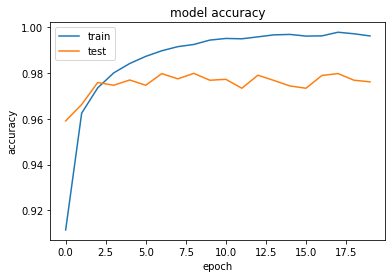

In [4]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
predictions_test = model.predict(x_test)

In [6]:
predictions_test.shape

(10000, 10)

In [7]:
predictions_train = model.predict(x_train)

## Check Model

Now that the initial model is trained, we need to train our check model.
We need to 

 1. come up with an initial transformation function for x
 2. figure out what shape the check model should be (preferable smaller than initial model)
 3. train so x' -> y'

#### Model 1: Let's try to simply sum up rows of pixels and learn the output from them.

In [9]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [10]:
x_train_check = np.zeros((60000,28,1), dtype=np.float32)
x_test_check = np.zeros((10000,28,1), dtype=np.float32)

In [11]:
# x_train_numpy = x_train.numpy()

In [12]:
for i in range(0,60000):
    x_train_check[i] = sum(x_train[i])

In [13]:
for i in range(0,10000):
    x_test_check[i] = sum(x_test[i])

In [14]:
x_train_check.shape

(60000, 28, 1)

In [15]:
sum(x_train[0]).shape

TensorShape([28, 1])

In [16]:
model_check = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,1)),
  tf.keras.layers.Dense(64,activation='relu'),
  tf.keras.layers.Dense(10)
])
model_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

train_stats = model_check.fit(
                x = x_train_check,
                y = y_train,
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_check, y_test),
                verbose=0
              )

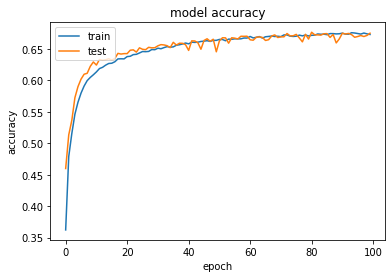

In [17]:
plt.plot(train_stats.history['sparse_categorical_accuracy'])
plt.plot(train_stats.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

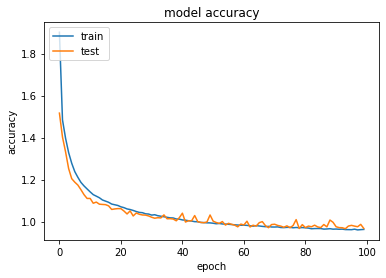

In [18]:
plt.plot(train_stats.history['loss'])
plt.plot(train_stats.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Result summary for model 1

This is basically just doing a worse, less accurate model.
It is only 60% accurate, meaning it is useless for detecting errors
We need to try so

#### Model 2:

For this model, let us sum across multiple inputs (temporally).

For example, lets say our batch size is 5. We sum up all the pixels across that batch
Similar to superimposing multiple images on top of eachother

We will also sum up the results (maybe the raw values, maybe 1 or zero)

Then we will train/test on that data. Worth a shot




In [24]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [108]:
concat_size = 5
train_len = int(60000/concat_size)
print(train_len)
test_len = int(10000/concat_size)
print(test_len)

12000
2000


In [109]:
x_train_check1 = np.zeros((train_len,28,28,1), dtype=np.float32)
x_test_check1 = np.zeros((test_len,28,28,1), dtype=np.float32)

In [110]:
predictions_train_check1 = np.zeros((train_len,10), dtype=np.float32)
predictions_test_check1 = np.zeros((test_len,10), dtype=np.float32)

In [111]:
j = 0
i = 0
while i < 60000:
    x_train_check1[j] = sum(x_train[i:i+5])/5
    #predictions_train_check1[j] = sum(tf.nn.softmax(predictions_train[i:i+5]))/5
    predictions_train_check1[j] = sum(tf.one_hot(y_train[i:i+5], 10))/5
    i+=5
    j+=1


In [112]:
j = 0
i = 0
while i < 10000:
    x_test_check1[j] = sum(x_test[i:i+5])/5
    #predictions_test_check1[j] = sum(tf.nn.softmax(predictions_test[i:i+5]))/5
    predictions_test_check1[j] = sum(tf.one_hot(y_test[i:i+5], 10))/5
    i+=5
    j+=1


In [113]:
# NOTE may need to normalize these by the concat size
# May also need to sum predictions_train/test in a different way
# and normalize

# TODO maybe try a different loss function. 
# This seems to be for single label
# or change the prediction so that there is a label for every
# different combo of numbers

In [123]:
model_check1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model_check1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

train_stats = model_check1.fit(
                x = x_train_check1,
                y = predictions_train_check1,
                shuffle=True,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_check1, predictions_test_check1),
                verbose=0
              )

ValueError: Both labels and logits must be provided.

In [121]:
plt.plot(train_stats.history['mean_absolute_error'])
plt.plot(train_stats.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'accuracy'

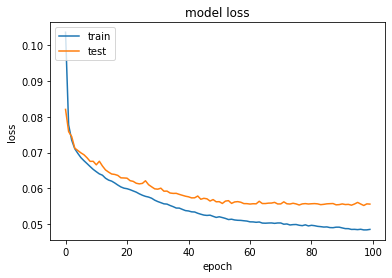

In [120]:
plt.plot(train_stats.history['loss'])
plt.plot(train_stats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
predictions_train[0]

array([-19.547142 ,   0.4695766, -16.668278 , -11.2909975,  16.404491 ,
        -6.861643 , -11.879002 ,  -1.7797058,  -4.4499993,   0.4074205],
      dtype=float32)

In [68]:
tf.nn.softmax(predictions_train)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2.4344667e-16, 1.2010315e-07, 4.3319035e-15, 9.3756697e-13,
       9.9999976e-01, 7.8640483e-11, 5.2075683e-13, 1.2667873e-08,
       8.7702068e-10, 1.1286521e-07], dtype=float32)>

In [95]:
y_train

<tf.Tensor: shape=(60000,), dtype=int64, numpy=array([4, 1, 0, ..., 6, 1, 5])>

In [98]:
tf.one_hot(y_train[0:5], 10)

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [99]:
y_train[0:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 1, 0, 7, 8])>